# **Project: Amazon Product Recommendation System**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163343 sha256=fae367e152f75565a8d560f604b9f17ad7146ab5e59d3d2171cf7cf865b28942
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# basic analytical libraries
import numpy as np
import pandas as pd

# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# dictionary output that does not raise a key error
from collections import defaultdict

# performance metrics in sklearn
from sklearn.metrics import mean_squared_error

# for ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# importing the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/ratings_Electronics.csv', header = None)

data.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # adding the column names

data = data.drop('timestamp', axis = 1) # dropping the timestamp column

df = data.copy(deep = True) # copying the data to another DataFrame 'df'

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# getting the column containing the users
users = df.user_id

# creating a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # if we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# to consider only users that have at least 50 ratings
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# getting the column containing the products
prods = df.prod_id

# creating a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # if we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# to consider only items with at least 5 ratings
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# checking the first 5 rows of the dataframe
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


- As shown by the indecies at the left, there are several entries that are excluded from the original dataset.

## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# checking the shape of the dataset
df_final.shape

(65290, 3)

- There are 65,290 rows and 3 columns.
- This dataset 0.8% of the amount of rows compared to the original dataset.

### **Data types**

In [ ]:
# checking the information summary of the DataFrame
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


- Both user_id and prod_id are the object data type, which makes sense.
- The rating variable is a float datatype, which will work for this analysis.
- Each variable contains the same amount of entries (65,290).

### **Checking for missing values**

In [ ]:
# checking for any missing values
df_final.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

- There are no missing values in this dataset.

### **Summary Statistics**

In [ ]:
# summary statistics of 'rating' variable
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


- The minimum rating is 1 and the maximum rating is 5, which makes sense.
- The average rating is ~4.3 with a standard deviation of ~1.0.
- The median rating is 5, which means the dataset is left skewed.
- At least half of the ratings are a score of 5.

### **Checking the rating distribution**

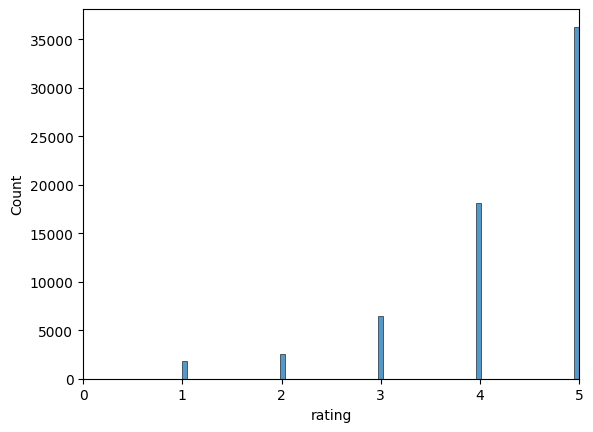

In [ ]:
# creating a bar plot for 'rating'
sns.histplot(data=df_final, x=df_final.rating) # a histogram
plt.xlim(0, 5)
plt.locator_params(axis='x', nbins=5)
plt.show()

- The most common rating is 5, which aligns with the data summary above.
- The ratings are more frequent for higher scores.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# checking the number of unique values in each column
df_final.nunique()

user_id    1540
prod_id    5689
rating        5
dtype: int64

- There are 5 unique ratings in this dataset, which makes sense.
- There are 1,540 unique users in this dataset.
- There are 5,689 unique products in this dataset.

### **Users with the most number of ratings**

In [ ]:
# top 10 users based on the number of ratings
df_final.groupby('user_id').size().sort_values(ascending = False)[:10]

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- See the user IDs above for the users with the top 10 number of ratings.
- The user with the most ratings is 'ADLVFFE4VBT8' with 295 ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# calculating the average rating for each product
avg_rating = df_final.groupby('prod_id').mean()['rating']

# calculating the count of ratings for each product
cnt_rating = df_final.groupby('prod_id').count()['rating']

# making dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':avg_rating, 'rating_count':cnt_rating})

# viewing the head of 'final_rating'
final_rating.head()

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [ ]:
# defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_prods(final_rating, n, min_interaction):

# finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]

# sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# recommending top 5 products with 50 minimum interactions based on popularity
res = list(top_n_prods(final_rating, 5, 50))
# product IDs
list_of_prods = []
for i in res:
    list_of_prods.append(df[df['prod_id']== str(i) ]['prod_id'].unique()[0])
list_of_prods

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

- The product IDs associated with the 5 products that are recommended with 50 minimum interactions are listed above.

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
# recommending top 5 products with 100 minimum interactions based on popularity
res2 = list(top_n_prods(final_rating, 5, 100))
# product IDs
list_of_prods2 = []
for i in res2:
    list_of_prods2.append(df[df['prod_id']== str(i) ]['prod_id'].unique()[0])
list_of_prods2

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

- The product IDs associated with the 5 products that are recommended with 50 minimum interactions are listed above.
- Most of the IDs in res2 are different than those in res, except for the product with ID 'B003ES5ZUU', which is in both lists.

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # mapping the predictions to each user
    user_est_true = defaultdict(list)

    # making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # sorting user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # when n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # when n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # printing the overall precision

    print('Recall: ', recall) # printing the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data2 = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# splitting the data into train and test datasets
trainset, testset = train_test_split(data2, test_size=0.3, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# initializing the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options,verbose=False)

# fitting the model on the training data
sim_user_user.fit(trainset)

# computing precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


- The baseline model has RMSE=1.025 on the test set.
- The preceision is the best, at 0.86; although recall (0.783) is still good.
- The F_1 score is 0.82 which is between precision and recall. This F_1 score shows that most of the time, the recommended products were relevent and the relevent products were recommended.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- The predicted rating for a sample user with an interacted product is 4.29, which is fairly close to its true rating of 5.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# finding unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A2ZR3YTMEEIIZ4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A2ZR3YTMEEIIZ4` and `prod_id=1400501466`.**

In [ ]:
# predicting rating for a sample user with a non interacted product
sim_user_user.predict('A2ZR3YTMEEIIZ4', 1400501466, verbose=True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2ZR3YTMEEIIZ4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- The predicted rating from this user for product 1400501466 is 4.29.

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options,verbose=False)

# training the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# computing precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


- This model has RMSE=1.0232 on the test set.
- The preceision is the best, at 0.835; although recall (0.758) is still good.
- The F_1 score is 0.795 which is between precision and recall. This F_1 score shows that most of the time, the predictions are accurate. However, this can be improved.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- This model predicts the rating of this user for product 1400501466 to be 4.29, which is fairly close to its true rating of 5.
- This model performs similarly to the basic user-user model.

Below we are **predicting rating for the `userId = A2ZR3YTMEEIIZ4` and `prod_id = 1400501466`**.

In [ ]:
# predicting rating for a sample user with a non interacted product
sim_item_item.predict('A2ZR3YTMEEIIZ4', 1400501466, verbose=True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2ZR3YTMEEIIZ4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- The predicted rating from user A3LDPF5FMB782Z for product 1400501466 is 4.29.
- This model performs similarly to the basic user-user model.

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# using SVD matrix factorization with random_state = 1
svd = SVD(random_state=1)

# training the algorithm on the trainset
svd.fit(trainset)

# using the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


- This model has RMSE=0.8989 on the test set.
- The preceision is the best, at 0.86; although recall (0.797) is still good.
- The F_1 score is 0.827 which is between precision and recall. This F_1 score shows that most of the time, the predictions are accurate. However, this can be improved.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# predicting rating for a sample user with an interacted product
svd.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.270673152607236, details={'was_impossible': False})

- The prediction from user A3LDPF5FMB782Z for item 1400501466 is 4.27, which is fairly close to the actual rating of 5.
- This prediction is slightly worse than those of the correlated original prediction from the first two models.

**Below we are predicting rating for the `userId = "A2ZR3YTMEEIIZ4"` and `productId = "1400501466"`.**

In [ ]:
# predicting rating for a sample user with a non interacted product
svd.predict('A2ZR3YTMEEIIZ4', 1400501466, verbose=True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.34   {'was_impossible': False}


Prediction(uid='A2ZR3YTMEEIIZ4', iid=1400501466, r_ui=None, est=4.3365436481111, details={'was_impossible': False})

- The prediction from user A3LDPF5FMB782Z for item 1400501466 is 4.34.

### **Conclusion and Recommendations**

1. In this case study, we built recommendation systems using four different algorithms. They are as follows:
  - Rank-based using averages
  - User-user similarity-based collaborative filtering
  - Item-item similarity-based collaborative filtering
  - Model-based (matrix factorization) collaborative filtering

2. To demonstrate "user-user similarity-based collaborative filtering", "item-item similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering", the surprise library has been used.

3. For performance evaluation of these models, precision@k and recall@k were used. Using these two metrics, the F_1 score is calculated for each model.

4. Overall, the Singular Value Decomposition (SVD) has given the best performance in terms of the F1-Score (~0.827).

5. Matrix Factorization has lower Root mean square error (RMSE) (0.8989) since it uses information from both users and products.

6. Hyperparameter tuning can be used to further improve the performance of these models.

7. Also, a more complex model can be built by combining different recommendation techniques, like hybrid recommendation systems.